### Callin Switzer
### Use RNN to process sounds



In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import os
import csv
import time
from scipy import signal
import itertools as it
import sys
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import scipy.io
import glob
import itertools

# Neural net libs
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")

print(sys.version, "\n")
print("last run on " + str(datetime.now()))

TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)] 

last run on 2018-10-05 07:10:45.745128


In [3]:

def windowsOrMacDirectories():
    """ Sets base directories for win or mac

       
    """
    if os.environ['COMPUTERNAME'] == 'SHEALMACLEARN':
        DropboxDirect = os.path.join("D:\Dropbox")
#     elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
#         # this excludes your current terminal "/dev/tty"
    elif sys.platform.startswith('darwin'):
        DropboxDirect = os.path.join("/Users/cswitzer/Dropbox")
    else:
        raise EnvironmentError('Unknown computer platform')
    
    baseDir = os.getcwd()
    dataDir = os.path.join(DropboxDirect, 'SonicationBehavior', 'SonBehData')
    figDir = os.path.join(DropboxDirect, 'SonicationBehavior', 'SonBehFigs')
    return baseDir, dataDir, figDir


baseDir, dataDir, figDir = windowsOrMacDirectories()
print(dataDir)

D:\Dropbox\SonicationBehavior\SonBehData


In [4]:
def readMyFile(filename):
    
    '''Read in csv 10x faster than pandas'''
    
    tmpdta = []
 
    with open(filename, newline="\n") as csvDataFile:
        csvReader = csv.reader(csvDataFile, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC)
        for row in csvReader:
            tmpdta.append(row)
 
    return(pd.DataFrame(np.transpose(tmpdta)))

In [5]:
# read in dataset that was pre-classified
buzzClassDataDir = os.path.join("D:\Dropbox\SonicationBehavior\SonBehData\BuzzPartClassification")
buzzClass = pd.read_csv(os.path.join(buzzClassDataDir, 'BuzzClassifications.csv'))
print(buzzClass.shape)
buzzClass.head()

(200, 7)


,fileName,noise1,noise2,wing1,wing2,buzz1,buzz2
0,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000
1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,10000,20000,0,10000
2,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000
3,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,3000,10000,12500,20000
4,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000


In [6]:
# read in all data into a single dataframe
bigList = []
freqSpec = []
for ii in range(buzzClass.shape[0]):
    tmp = readMyFile(buzzClass.fileName[ii])
    
#     # pad with 0's
#     tmp = readMyFile(buzzClass.fileName[ii])
#     pad = np.arange(tmp.iloc[-1,0],tmp.iloc[-1,0]+ 0.02 - np.mean(np.diff(tmp.iloc[:,0])),  np.mean(np.diff(tmp.iloc[:,0])))
#     zx = np.repeat(0, len(pad))
#     pdff = pd.DataFrame( data = {"0":pad, "1":zx} )
#     pdff.columns = tmp.columns

#     tmp = pd.concat([tmp, pdff]).reset_index(drop = True)
    
    # calculate rolling variance
    tmp["varia"] = pd.Series((tmp.iloc[:,1] - np.mean(tmp.iloc[:,1]))).rolling(int(2000), center = True, min_periods = 1).var().tolist()
    
    # calculate frequency spectrum
    f, t, Sxx = signal.spectrogram(tmp.iloc[:,1], 200000, noverlap = 900, nperseg = 1000)
    Sxx = Sxx[0:50, :]
    #scale
    Sxx = Sxx - np.min(Sxx)
    Sxx = Sxx / np.max(Sxx)
    
    
    
    freqSpec.append(pd.DataFrame(np.transpose(Sxx)))
    
    # add classes to data
    tmp["buzz"] = 0
    tmp.loc[buzzClass.buzz1[ii]:buzzClass.buzz2[ii], "buzz"] = 1
    if(np.mod(ii, 10)) == 0:
        print(ii)
    
    tmp["filename"] = buzzClass.fileName[ii]
    bigList.append(tmp)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [7]:
tmp.head()

,0,1,varia,buzz,filename
0,0.000000,0.063874,0.006357,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
1,0.000005,0.061602,0.006352,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
2,0.000010,0.060953,0.006348,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
3,0.000015,0.059655,0.006343,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
4,0.000020,0.059331,0.006339,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...


In [421]:
df = pd.concat(bigList)
df.reset_index(drop = True, inplace = True)

In [422]:
df.head()

,0,1,varia,buzz,filename
0,0.000000,0.001246,0.002879,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
1,0.000005,0.001571,0.002876,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
2,0.000010,-0.001999,0.002873,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
3,0.000015,0.002544,0.002871,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
4,0.000020,0.004167,0.002869,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...


In [423]:
df.rename( columns={1: "acc"}, inplace=True)

In [424]:
# scale data
from sklearn.preprocessing import minmax_scale

df['acc_scaled'] = df.groupby('filename').acc.transform(lambda x: minmax_scale(x.astype(float), feature_range = (-1,1)))

# from sklearn.preprocessing import robust_scale
# df['acc_scaled'] = df.groupby('filename').acc.transform(lambda x: scale(x.astype(float)))


df.head()

,0,acc,varia,buzz,filename,acc_scaled
0,0.000000,0.001246,0.002879,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0.086992
1,0.000005,0.001571,0.002876,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0.087805
2,0.000010,-0.001999,0.002873,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0.078862
3,0.000015,0.002544,0.002871,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0.090244
4,0.000020,0.004167,0.002869,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0.094309


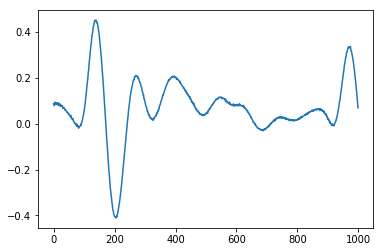

In [425]:
plt.plot(np.array(df.acc_scaled[0:1000]))

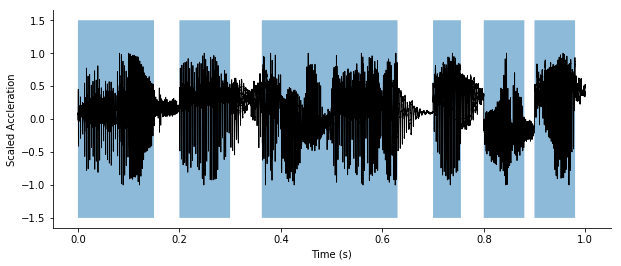

In [426]:

#plt.plot(np.array(df.iloc[0:200000, 3]))

ss = 3

y1 = np.array(df.iloc[0:200000, 3])*ss - 0.5*ss
xx = np.linspace(0, len(y1) / 200000,num = len(y1) )
y2 = np.array(df.iloc[0:200000, 5])


fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(1, 1, 1)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.plot(xx, y2, linewidth = 0.9, c = 'black')
ax.fill_between(xx,y1,-0.5*ss, alpha = 0.5, linewidth = 0)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Scaled Accleration")
#ax.set_ylim(-0.5, 1.5)
#plt.xticks([])
#plt.yticks([])

plt.savefig(os.path.join(figDir, "NNSeq1.png"), dpi = 500)

In [429]:
# downsample
dss = np.arange(0, df.shape[0], step = 4)

Y = pd.DataFrame(df.loc[dss, "buzz"].values)
X =  pd.DataFrame(df.loc[dss, "acc_scaled"].values)
X.shape

(1000000, 1)

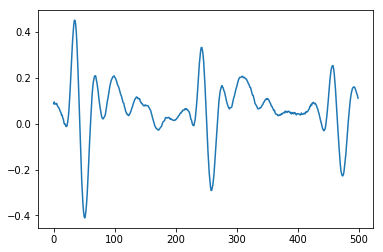

In [430]:
plt.plot(X[0:500])

In [431]:
# add windows
for s in np.arange(1, 500):
    X['shift_{}'.format(s)] = X[0].shift(s)
    X['shift_{}'.format(s)] = X[0].shift(s)


In [432]:
split_index=  int(0.8*X.shape[0])

train_x = X[:split_index].copy()
test_x = X[split_index:].copy()

train_y = Y[:split_index].copy()
test_y = Y[split_index:].copy()

In [433]:
test_y.head()

,0
800000,0
800001,0
800002,0
800003,0
800004,0


In [434]:
train_x.head()

,0,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,...,shift_490,shift_491,shift_492,shift_493,shift_494,shift_495,shift_496,shift_497,shift_498,shift_499
0,0.086992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.094309,0.086992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.084553,0.094309,0.086992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.086992,0.084553,0.094309,0.086992,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.086992,0.086992,0.084553,0.094309,0.086992,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [435]:
train_x.iloc[:, 0] = train_y.iloc[:,0]

In [436]:
X_train = train_x.dropna().drop(0, axis=1)
y_train = train_x.dropna()[[0]]

X_test = test_x.dropna().drop(0, axis=1)
y_test = test_y.dropna()[[0]]

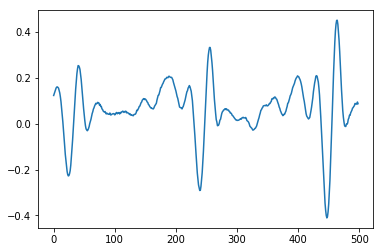

In [437]:
plt.plot(np.array(X_train.iloc[0,:]))

In [438]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

In [439]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((799501, 499), (200000, 499), (799501, 1), (200000, 1))

In [440]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.layers import BatchNormalization
import keras.backend as K
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=10, 
                          verbose=1, mode='auto', min_delta = 0.01)

# fully connected network with on windows

In [394]:
K.clear_session()

model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], activation='tanh'))
model.add(Dense(64, activation='tanh'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(64, activation='tanh'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(16, activation='tanh'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 500       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 5,845
Trainable params: 5,845
Non-trainable params: 0
_________________________________________________________________


In [397]:
history = model.fit(X_train, y_train, epochs=10, batch_size=2**16, 
                    callbacks = [earlystop], validation_data=(X_test, y_test))

Train on 106168 samples, validate on 26667 samples
Epoch 1/10
106168/106168 [==============================] - 1s 11us/step - loss: 0.6041 - binary_accuracy: 0.7047 - val_loss: 0.5950 - val_binary_accuracy: 0.7198
Epoch 2/10
106168/106168 [==============================] - 1s 11us/step - loss: 0.6039 - binary_accuracy: 0.7114 - val_loss: 0.5942 - val_binary_accuracy: 0.7299
Epoch 3/10
106168/106168 [==============================] - 1s 11us/step - loss: 0.6028 - binary_accuracy: 0.7166 - val_loss: 0.5916 - val_binary_accuracy: 0.7299
Epoch 4/10
106168/106168 [==============================] - 1s 11us/step - loss: 0.6007 - binary_accuracy: 0.7182 - val_loss: 0.5883 - val_binary_accuracy: 0.7299
Epoch 5/10
106168/106168 [==============================] - 1s 11us/step - loss: 0.5986 - binary_accuracy: 0.7182 - val_loss: 0.5856 - val_binary_accuracy: 0.7299
Epoch 6/10
106168/106168 [==============================] - 1s 11us/step - loss: 0.5973 - binary_accuracy: 0.7182 - val_loss: 0.5839 -

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


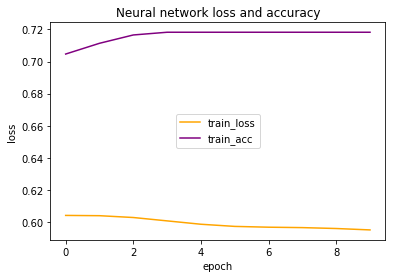

In [399]:
print(history.history.keys())


plt.plot(history.history['loss'], c = "orange")
plt.title('Neural network loss and accuracy')
plt.ylabel('loss')

plt.xlabel('epoch')




plt.plot(history.history['binary_accuracy'], c = "purple")
plt.legend(['train_loss', 'train_acc'], loc='center')


plt.show()

In [400]:
pred = model.predict(X_test)

In [410]:
from sklearn.metrics import accuracy_score
accuracy_score(np.array(y_test)[0:50000], ((np.array(pred) > 0.6) * 1)[0:50000])

0.7208159898001275

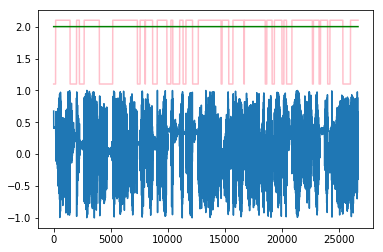

In [411]:
plt.plot(X_test[0:100000, 0])
plt.plot(np.array(y_test)[0:100000] + 1.1, c= 'pink')
plt.plot((np.array(pred)[0:100000] > 0.5) + 1, c= 'green')

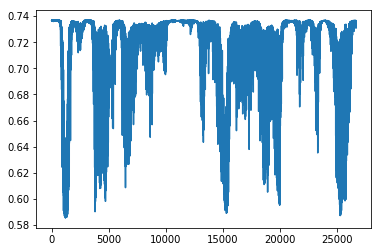

In [412]:
plt.plot(np.array(pred))

In [413]:
X_train.shape

(106168, 499)

# USE LSTM

In [441]:
X_train_t = X_train.reshape(X_train.shape[0], 1, -1)
X_test_t = X_test.reshape(X_test.shape[0], 1, -1)

In [442]:
K.clear_session()
model = Sequential()
model.add(LSTM(64, input_shape = (1, X_train_t.shape[2]), return_sequences=True, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(6, return_sequences = True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(6, activation = "tanh"))
model.add(Dense(1, activation = "sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics =['binary_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta =0.01)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=20, min_lr=0.00001)

In [453]:
hist = model.fit(X_train_t, y_train, epochs=10, validation_data = (X_test_t, y_test),
          batch_size=2**12, verbose=2,
          callbacks=[early_stop, reduce_lr])

Train on 799501 samples, validate on 200000 samples
Epoch 1/10
 - 13s - loss: 0.1654 - binary_accuracy: 0.9358 - val_loss: 0.2387 - val_binary_accuracy: 0.9234
Epoch 2/10
 - 13s - loss: 0.1649 - binary_accuracy: 0.9359 - val_loss: 0.2507 - val_binary_accuracy: 0.9205
Epoch 3/10
 - 12s - loss: 0.1642 - binary_accuracy: 0.9364 - val_loss: 0.2468 - val_binary_accuracy: 0.9159
Epoch 4/10
 - 13s - loss: 0.1627 - binary_accuracy: 0.9372 - val_loss: 0.2389 - val_binary_accuracy: 0.9223
Epoch 5/10
 - 13s - loss: 0.1617 - binary_accuracy: 0.9374 - val_loss: 0.2521 - val_binary_accuracy: 0.9241
Epoch 6/10
 - 13s - loss: 0.1617 - binary_accuracy: 0.9374 - val_loss: 0.2498 - val_binary_accuracy: 0.9201
Epoch 7/10
 - 13s - loss: 0.1600 - binary_accuracy: 0.9378 - val_loss: 0.2376 - val_binary_accuracy: 0.9246
Epoch 8/10
 - 13s - loss: 0.1595 - binary_accuracy: 0.9381 - val_loss: 0.2485 - val_binary_accuracy: 0.9185
Epoch 9/10
 - 13s - loss: 0.1588 - binary_accuracy: 0.9384 - val_loss: 0.2446 - val_

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy', 'lr'])


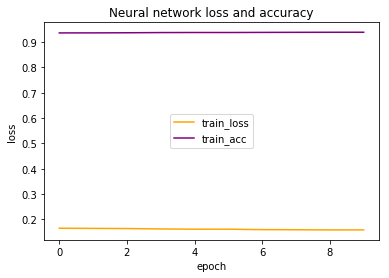

In [458]:
print(hist.history.keys())


plt.plot(hist.history['loss'], c = "orange")
plt.title('Neural network loss and accuracy')
plt.ylabel('loss')

plt.xlabel('epoch')




plt.plot(hist.history['binary_accuracy'], c = "purple")
plt.legend(['train_loss', 'train_acc'], loc='center')


plt.show()

In [470]:
pred = model.predict(X_test_t)

In [472]:
pred.reshape(-1)

array([0.99811006, 0.99779093, 0.99752635, ..., 0.9937296 , 0.9929616 ,
       0.99229926], dtype=float32)

In [646]:
# remove noise with rolling mean
smooth_data = pd.Series(pred.reshape(-1)> 0.5).rolling(window=200, center = True).median()
from sklearn.metrics import accuracy_score
accuracy_score(y_test.reshape(-1)[0:100000], smooth_data.values.astype(int)[0:100000])

0.94004

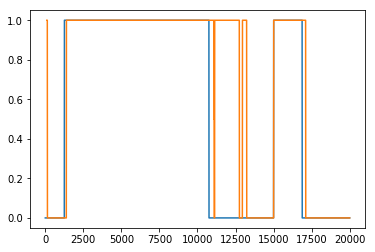

In [647]:
plt.plot((y_test.reshape(-1)> 0.5)[0:20000])
plt.plot(np.arange(0, 20000), smooth_data[:20000])

In [648]:
smooth_data.values.astype(int)

array([-2147483648, -2147483648, -2147483648, ..., -2147483648,
       -2147483648, -2147483648])

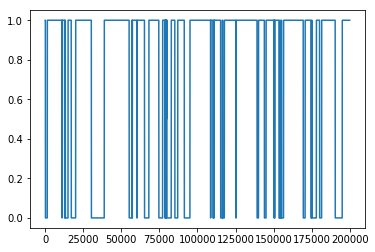

In [649]:
plt.plot(smooth_data)

In [650]:
from sklearn.metrics import accuracy_score
accuracy_score(np.array(y_test)[0:50000], ((np.array(pred) > 0.5) * 1)[0:50000])

0.92862

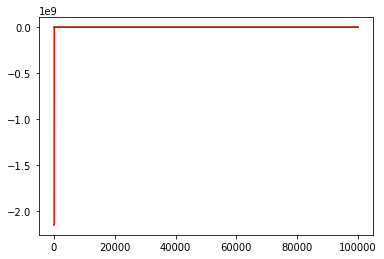

In [652]:
plt.plot(X_test[0:100000, 0])
plt.plot(np.array(y_test)[0:100000] + 1.1, c= 'pink')
plt.plot((np.array(pred)[0:100000] > 0.7) + 1, c= 'green')
plt.plot(smooth_data.values.astype(int)[: 100000] + 1.2, c= 'red')

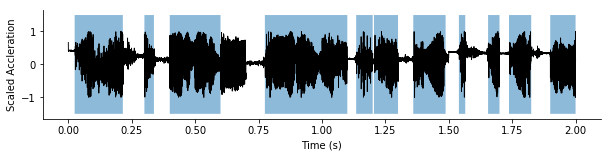

In [653]:

#plt.plot(np.array(df.iloc[0:200000, 3]))

ss = 3

y1 = y_test[0:100000, 0]*ss - 0.5*ss
xx = np.linspace(0, len(y1) / 200000 *4,num = len(y1) )
y2 = X_test[0:100000, 0]


fig = plt.figure(figsize = (10,2))
ax = fig.add_subplot(1, 1, 1)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.plot(xx, y2, linewidth = 0.9, c = 'black')
ax.fill_between(xx,y1,-0.5*ss, alpha = 0.5, linewidth = 0)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Scaled Accleration")
#ax.set_ylim(-0.5, 1.5)
#plt.xticks([])
#plt.yticks([])


plt.savefig(os.path.join(figDir, "NNSeq_test.png"), dpi = 500)

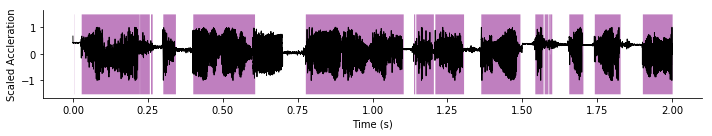

In [654]:

#plt.plot(np.array(df.iloc[0:200000, 3]))

ss = 3

# y1 = (np.array(pred)[0:100000, 0] > 0.5)*ss - 0.5*ss
y1 = smooth_data[0:100000] *ss - 0.5*ss
xx = np.linspace(0, len(y1) / 200000 *4,num = len(y1) )
y2 = X_test[0:100000, 0]


fig = plt.figure(figsize = (10,2))
ax = fig.add_subplot(1, 1, 1)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.plot(xx, y2, linewidth = 0.9, c = 'black')
ax.fill_between(xx,y1,-0.5*ss, alpha = 0.5, linewidth = 0, color = 'purple')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Scaled Accleration")
#ax.set_ylim(-0.5, 1.5)
#plt.xticks([])
#plt.yticks([])
plt.tight_layout()

plt.savefig(os.path.join(figDir, "NNSeq_pred.png"), dpi = 500)

# plot accuracy of diff networks

In [655]:
DenseFff = 73
lstmMod = 94
Conv1D = 90

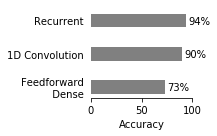

In [657]:
fig, ax = plt.subplots(figsize = [3,2])

# Example data
models = ("Recurrent", "1D Convolution", " ")
y_pos = np.arange(len(models))
performance = np.array([94, 90, 73])


ax.barh(y_pos, performance, align='center',
        color='grey', ecolor='black', height = 0.4)
ax.set_yticks(y_pos)
ax.set_yticklabels(models)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accuracy')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('none') 
ax.set_xlim(0, 100)

for i, v in enumerate(performance):
    ax.text(v + 2, i + 0.1, str(v) + "%", color='black')
    
ax.annotate('Feedforward\n          Dense', xy=(-69, 2.3), annotation_clip=False)

plt.tight_layout()
fig.savefig(os.path.join(figDir, "NNSeq_Perf.svg"), transparent = True)

In [535]:
figDir

'D:\\Dropbox\\SonicationBehavior\\SonBehFigs'